## Importing Libs

In [10]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

## Reading dataset

In [11]:
dataset = genfromtxt('clustering_data.csv', delimiter = ',')

## Creating Funcs

### Normalizing funcs

In [12]:
def NormalizeZScore(dataset: np.ndarray):
    mean = np.mean(dataset, axis = 0)
    std = np.std(dataset, axis = 0)
    n_data = (dataset - mean)/std
    return n_data, mean, std

def NormalizePoint(p, mean, std):
    return (p-mean)/std

def DenormalizePoint(p, mean, std):
    return (p*std) + mean

### k-means

In [13]:
def KMeans(data: np.array, k: int, seed: int):
  rng = np.random.default_rng(seed = seed)
  m = np.ndarray((k, data.shape[1]))
  m[0] = rng.choice(data)
  for i in range(1, k):
    distances = np.ndarray((data.shape[0], i))
    for j in range(i):
      distances[ : , j] = np.apply_along_axis(func1d = lambda x: np.sqrt(np.sum((x-m[j])**2)), axis = 1, arr = data)
    min_distances = np.min(distances, axis = 1)
    min_sum = np.sum(min_distances)
    min_distances = min_distances/min_sum
    m[i] = rng.choice(data, p = min_distances)
  var = np.inf
  while var > 0.1:
    m_v = m.copy()
    clustered = np.apply_along_axis(func1d = lambda x: np.argmin(np.sqrt(np.sum((x - m)**2, axis = 1))), axis = 1, arr = data)
    for i in range(k):
      m[i] = np.mean(data[clustered == i], axis = 0)
    var = np.mean(np.sqrt(np.sum((m - m_v)**2)))
  error = 0
  for i in range(k):
    error += np.sum((data[clustered == i] - m[i])**2)
  return m, error, clustered

### GMM

In [14]:
def GMM(dataset: np.ndarray, K: int):
  alpha = np.ones(K)
  mi0 = np.mean(dataset, axis = 0)
  k0 = 0.01
  v0 = dataset.shape[1] + 2
  S0 = np.cov(dataset.T)/(K**(2/dataset.shape[1]))
  kmeans_m = []
  kmeans_error = np.empty(10)
  kmeans_clustered = []
  for i in range(10):
    temp_m, temp_error, temp_c = KMeans(dataset, K, i)
    kmeans_m.append(temp_m)
    kmeans_error[i] = (temp_error)
    kmeans_clustered.append(temp_c)
  idx = np.argmin(kmeans_error)
  mi_array = kmeans_m[idx]
  clustered = kmeans_clustered[idx]
  pi_array = np.empty(K)
  cov_array = np.ones((K, dataset.shape[1], dataset.shape[1]))
  x_k = np.empty((K,dataset.shape[1]))
  for i in range(K):
    pi_array[i] = np.sum(clustered == i)/dataset.shape[0]
    cov_array[i] = np.cov(dataset[clustered == i].T)
  r = np.empty((K, dataset.shape[0]))
  print()
  for i in range(20):
    for j in range(K):
      r[j] = pi_array[j] * (multivariate_normal(mi_array[j],cov_array[j]).pdf(dataset))
    r = r / np.sum(r, axis = 0)
    for j in range(K):
      pi_array[j] = (alpha[j] - 1 + np.sum(r[j]))/(dataset.shape[0] - K + np.sum(alpha))
      x_k[j] = np.sum(r[j].reshape((-1, 1)) * dataset, axis = 0)/np.sum(r[j])
      mi_array[j] = (k0*mi0 + (x_k[j]*np.sum(r[j])))/(k0 + np.sum(r[j]))
      cov_array[j] = (S0 + (r[j]*(dataset - x_k[j]).T @(dataset - x_k[j])) + ((((k0*np.sum(r[j])/(k0 + np.sum(r[j])))*((x_k[j] - mi0))).T)@(x_k[j] - mi0)))/(v0 + dataset.shape[1] + 2 + np.sum(r[j]))
  return pi_array, mi_array, cov_array


In [15]:
def gmm_prob(data, pi_array, mi_array, cov_array):
  K = pi_array.shape[0]
  probs = np.empty(K)
  for i in range(K):
    probs[i] = pi_array[i] * multivariate_normal(mi_array[i], cov_array[i]).pdf(data)
  return np.sum(probs, axis = 0)

## Test

In [16]:
data_n, mean, std = NormalizeZScore(dataset = dataset)

In [17]:
ks = [2, 4, 6, 8, 10]

In [18]:
pi = []
mi = []
cov = []
for k in ks:
  pi_temp, mi_temp, cov_temp = GMM(data_n, k)
  pi.append(pi_temp)
  mi.append(mi_temp)
  cov.append(cov_temp)

In [19]:
x1, x2 = np.mgrid[slice(np.min(dataset[:,0]) - 1, np.max(dataset[:, 0]) + 1, 0.1),
                  slice(np.min(dataset[:,1]) - 1, np.max(dataset[:, 1]) + 1, 0.1)]
x_plot = np.dstack((x1, x2))
x_plot_n = np.apply_along_axis(func1d = NormalizePoint, arr = x_plot, axis = 2, mean = mean, std = std)
values = [np.apply_along_axis(func1d = gmm_prob, arr = x_plot_n, axis = 2, pi_array = pi[k], mi_array = mi[k], cov_array = cov[k]) for k in range(len(ks))]

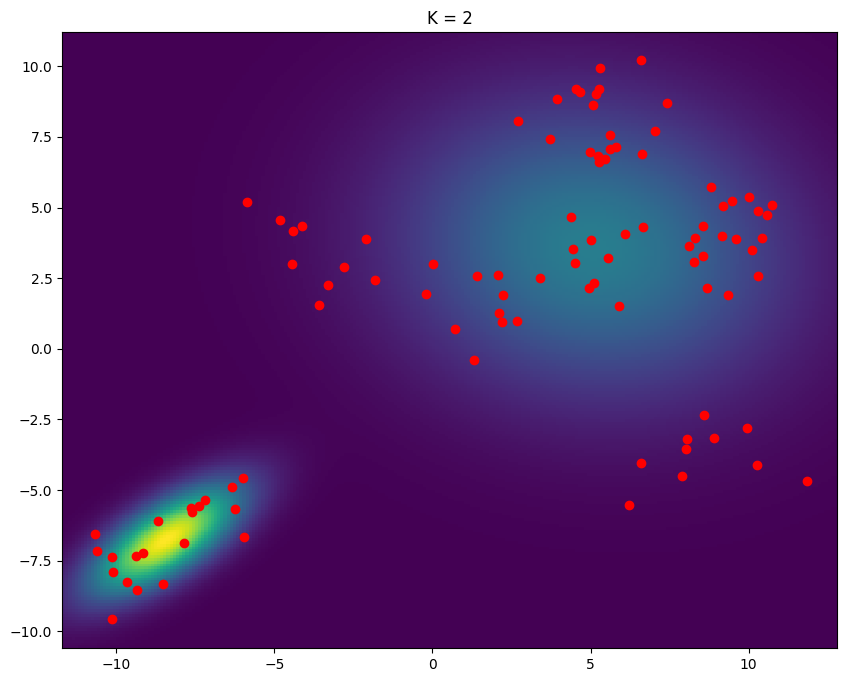

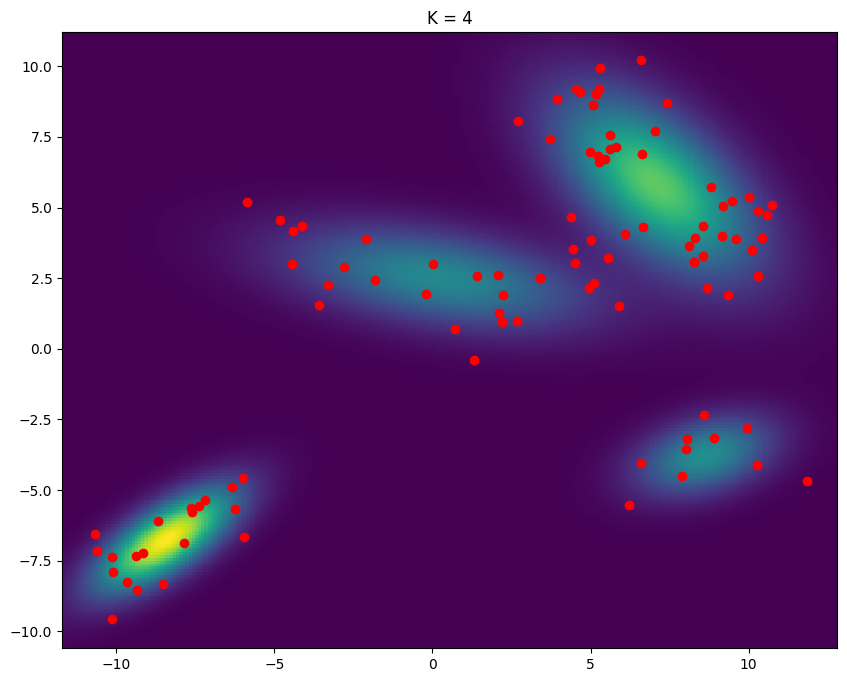

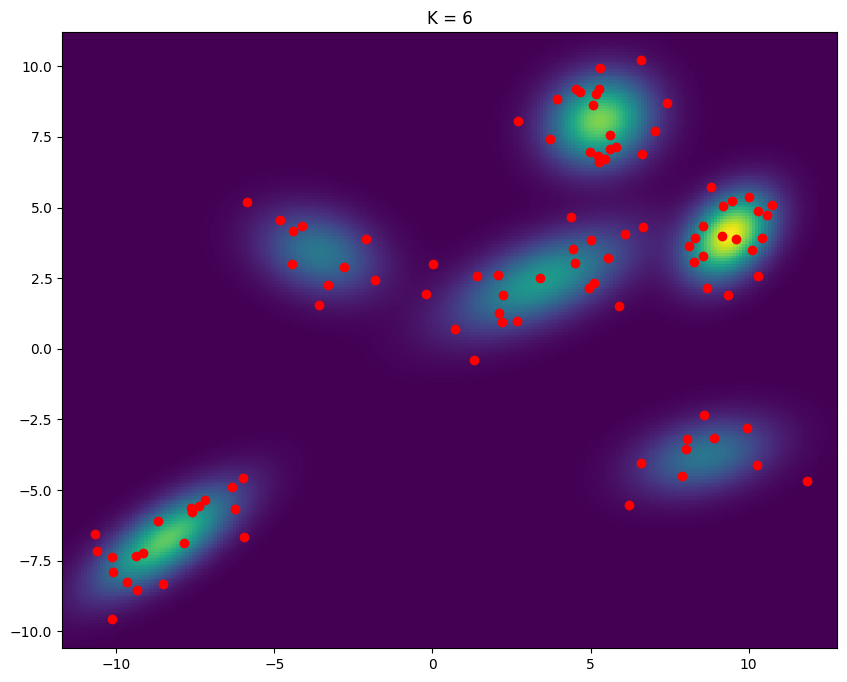

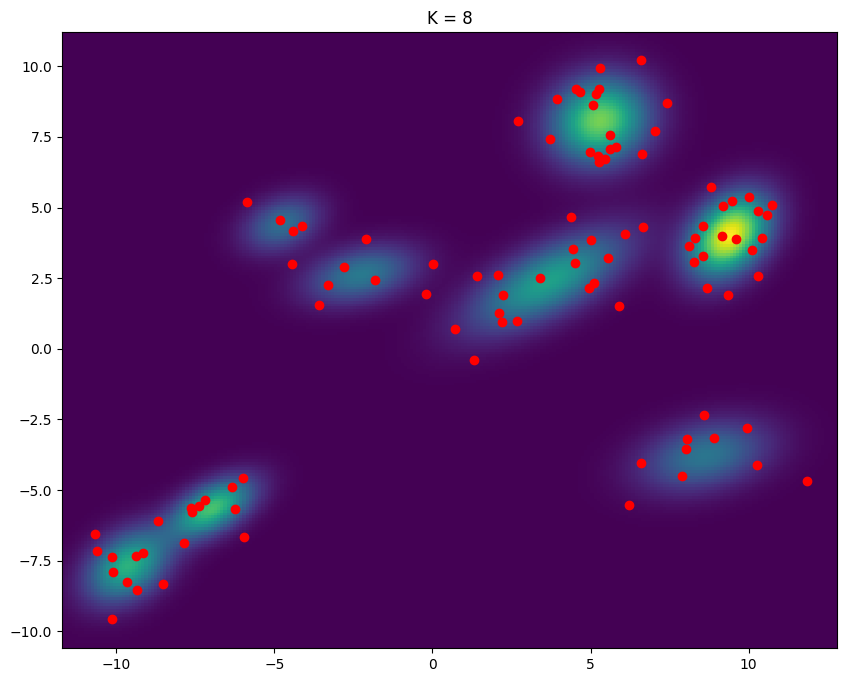

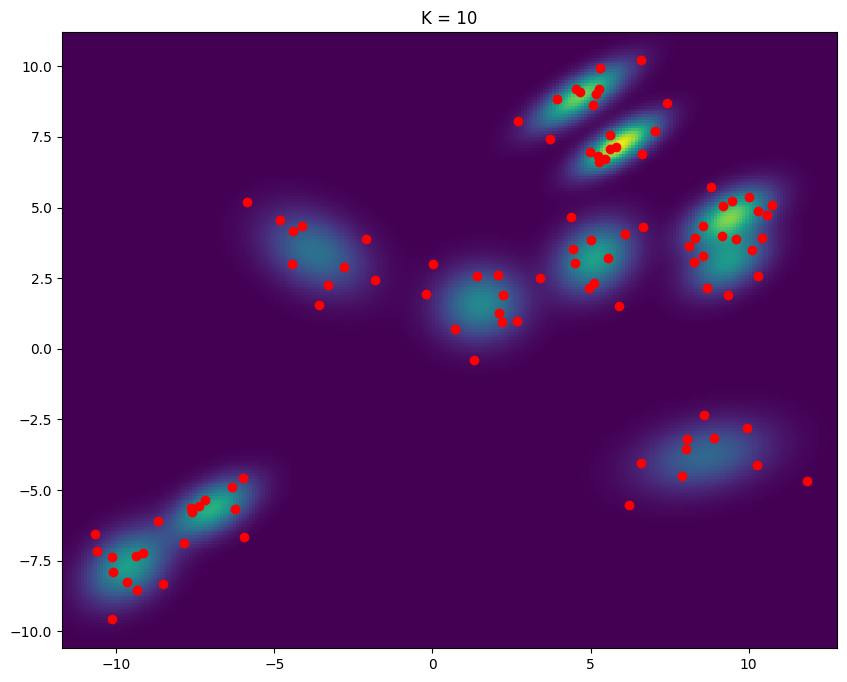

In [20]:
for k in range(len(ks)):
  plt.figure(figsize=(10,8))
  back = plt.pcolormesh(x1, x2, values[k], cmap = 'viridis')
  scatter = plt.scatter(dataset[:, 0], dataset[:, 1], color = 'red')
  plt.title(f"K = {ks[k]}")
  plt.show()